<a href="https://colab.research.google.com/github/ykitaguchi77/VGGface2_pretrain/blob/master/VGGFace_pretrain_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Resnet50_ImageNet**

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


'''
grav: 甲状腺眼症
cont: コントロール
黒の空白を挿入することにより225px*225pxの画像を生成、EfficientNetを用いて転移学習
－－－－－－－－－－－－－－
データの構造
gravcont.zip ------grav
               |---cont
'''                                     

#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

!date -R
!unzip -qq drive/My\ Drive/Deep_learning/VGGFace_small.zip
!date -R
!ls

Random Seed:  1234
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Fri, 26 Jun 2020 06:35:37 +0000
Fri, 26 Jun 2020 06:35:45 +0000
drive  sample_data  train  val


#**モジュール群**

['n000002', 'n000003', 'n000004', 'n000005', 'n000006', 'n000007', 'n000008', 'n000010']
n000002_train:252
n000003_train:164
n000004_train:309
n000005_train:183
n000006_train:388
n000007_train:207
n000008_train:218
n000010_train:124
n000002_val:63
n000003_val:41
n000004_val:78
n000005_val:46
n000006_val:97
n000007_val:52
n000008_val:55
n000010_val:32
training data set_total：1845
validating data set_total：464


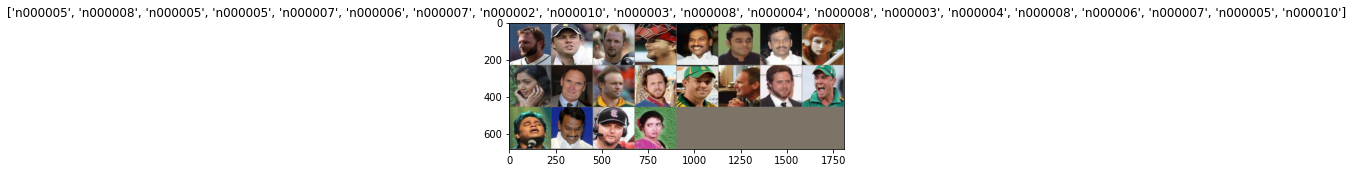

In [4]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content'
n_samples = len(data_dir)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path='/content/train/'+class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path='/content/val/'+class_names[k]))))
    k+=1

print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))


#少数の画像を可視化
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


#Defining early stopping class
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, scheduler, patience, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
                scheduler.step()
                print('epoch:{}, lr:{}'.format(epoch, scheduler.get_lr()[0]))
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss


#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


#LRschedulerのバグ修正
#https://colab.research.google.com/drive/1idL-NPUvomAWzj_EVn2QccQVwQgEoGrJ

_LRScheduler = torch.optim.lr_scheduler._LRScheduler

class StepLR(_LRScheduler):
    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1):
        self.step_size = step_size
        self.gamma = gamma
        super(StepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** (self.last_epoch // self.step_size)
                for base_lr in self.base_lrs]


class MultiStepLR(_LRScheduler):
    def __init__(self, optimizer, milestones, gamma=0.1, last_epoch=-1):
        if not list(milestones) == sorted(milestones):
            raise ValueError('Milestones should be a list of'
                             ' increasing integers. Got {}', milestones)
        self.milestones = milestones
        self.gamma = gamma
        super(MultiStepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.gamma ** bisect_right(self.milestones, self.last_epoch)
                for base_lr in self.base_lrs]

#**ConvNetの調整**

In [5]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[5, 12, 20, 30], gamma=0.1)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [4]:
print(device)

cuda:0


#**訓練と評価**

In [6]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, patience=5, num_epochs=50)

Epoch 0/49
----------
epoch:0, lr:0.01
train Loss: 0.9438 Acc: 0.7003


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


val Loss: 1.8455 Acc: 0.7349
Validation loss decreased (inf --> 1.845496).  Saving model ...

Epoch 1/49
----------
epoch:1, lr:0.01
train Loss: 0.6080 Acc: 0.8136
val Loss: 1.9050 Acc: 0.7026
EarlyStopping counter: 1 out of 5

Epoch 2/49
----------
epoch:2, lr:0.01
train Loss: 0.3793 Acc: 0.8737
val Loss: 0.2589 Acc: 0.9353
Validation loss decreased (1.845496 --> 0.258892).  Saving model ...

Epoch 3/49
----------
epoch:3, lr:0.01
train Loss: 0.2558 Acc: 0.9214
val Loss: 0.4046 Acc: 0.8664
EarlyStopping counter: 1 out of 5

Epoch 4/49
----------
epoch:4, lr:0.0001
train Loss: 0.2154 Acc: 0.9322
val Loss: 0.2300 Acc: 0.9267
Validation loss decreased (0.258892 --> 0.230017).  Saving model ...

Epoch 5/49
----------
epoch:5, lr:0.001
train Loss: 0.0499 Acc: 0.9854
val Loss: 0.0951 Acc: 0.9655
Validation loss decreased (0.230017 --> 0.095140).  Saving model ...

Epoch 6/49
----------
epoch:6, lr:0.001
train Loss: 0.0543 Acc: 0.9837
val Loss: 0.0845 Acc: 0.9720
Validation loss decreased (0

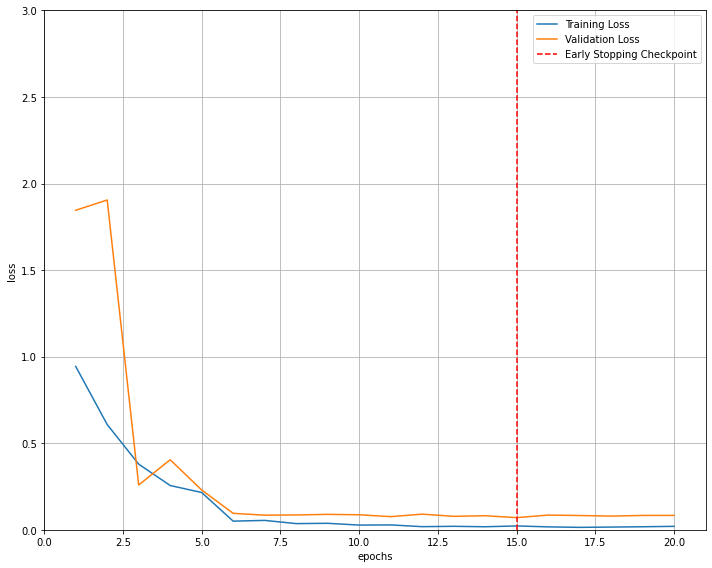

In [7]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 3.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

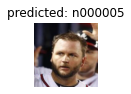

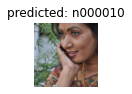

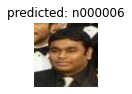

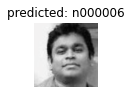

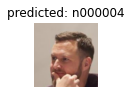

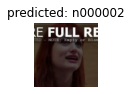

In [8]:
visualize_model(model_ft)

In [37]:
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for data in dataloaders['val']:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of n000002 : 100 %
Accuracy of n000003 : 100 %
Accuracy of n000004 : 100 %
Accuracy of n000005 : 100 %
Accuracy of n000006 : 94 %
Accuracy of n000007 : 100 %
Accuracy of n000008 : 100 %
Accuracy of n000010 : 77 %
